In [1]:
# Importing required libraries

import warnings
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Number of replicas: 1


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32 * strategy.num_replicas_in_sync

image_size = [224,224]

class_name = ["NORMAL","PNEUMONIA"]

In [4]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)

train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

In [5]:
count_normal = len([file_name for file_name in train_paths if "NORMAL" in file_name.numpy().decode("utf-8")])
print(f'Normal data count : {count_normal}')

p_count_normal = len([file_name for file_name in train_paths if "PNEUMONIA" in file_name.numpy().decode("utf-8")])
print(f'PNEUMONIA data count : {p_count_normal}')

print(f'total {count_normal + p_count_normal}')



Normal data count : 1349
PNEUMONIA data count : 3883
total 5232


# Fixing class imbalance using class weights

In [6]:
total_img_count = count_normal + p_count_normal
weight_for_0 = (1/count_normal)*(total_img_count)/2.0

weight_for_1 = (1/p_count_normal)*(total_img_count)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

{0: 1.939214232765011, 1: 0.6737058975019315}


In [7]:
def get_label(file_path):
    parts = tf.strings.split(file_path,"/")
    return parts[-2]=="PNEUMONIA"

def decode_img(img):
    img = tf.image.decode_jpeg(img,channels=3)
    return tf.image.resize(img,size=image_size)

def process_path(image,path):
    label = get_label(path)
    img = decode_img(image)
    return img,label

ds = ds.map(process_path,num_parallel_calls=AUTOTUNE)

In [8]:
ds = ds.shuffle(10000)
train_ds = ds.take(5000)
val_ds = ds.skip(5000)

In [9]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)

COUNT_NORMAL = len([filename for filename in test_paths if "NORMAL" in filename.numpy().decode("utf-8")])
print("Normal images count in test set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in test_paths if "PNEUMONIA" in filename.numpy().decode("utf-8")])
print("Pneumonia images count in test set: " + str(COUNT_PNEUMONIA))

Normal images count in test set: 234
Pneumonia images count in test set: 390


In [30]:
test_ds = tf.data.Dataset.zip((test_images,test_paths))
test_ds = test_ds.map(process_path,num_parallel_calls=AUTOTUNE)
test_ds_batch = test_ds.batch(batch_size)


In [11]:
def prepare_for_training(ds,cache=True):
    ds = ds.cache() #cache the dataset that don't fit in memory
    ds = ds.batch(batch_size)

    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


In [12]:
train_ds_batch = prepare_for_training(train_ds)
val_ds_batch = prepare_for_training(val_ds)

image_batch , label_batch = next(iter(train_ds_batch))


In [13]:
def show_batch(image_batch,label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n]/255)
        if(label_batch[n]):
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")


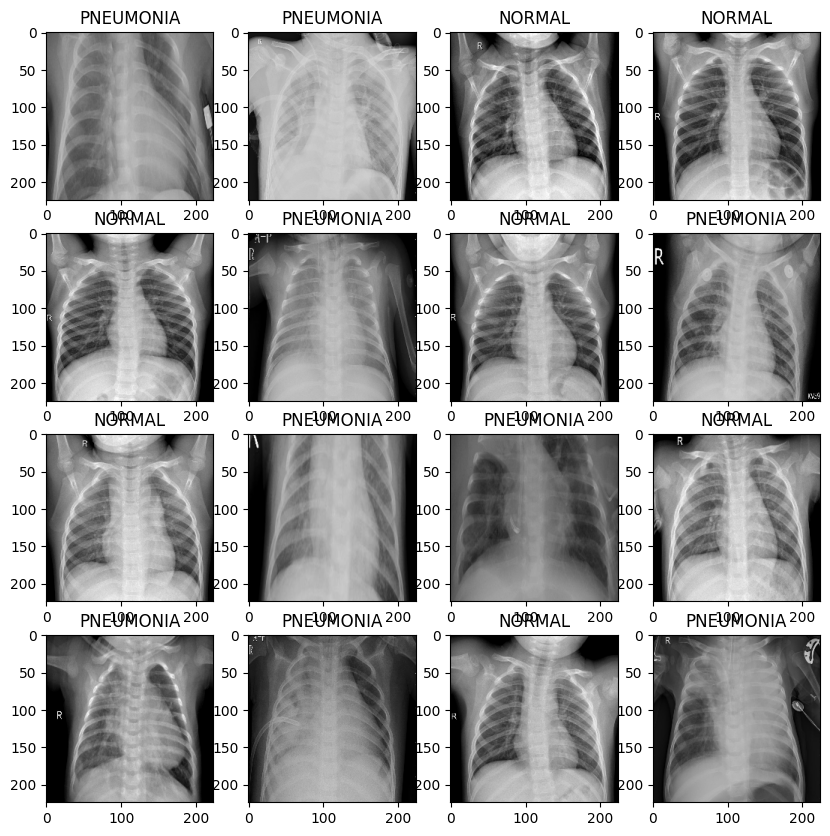

In [14]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [15]:
def build_model():

    mobilenet_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
    )

    for layers in mobilenet_model.layers[:-2]:
        layers.trainable = False

    x = mobilenet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128,activation="relu")(x)
    output = tf.keras.layers.Dense(1,activation="sigmoid")(x)
    pretrained_model = tf.keras.Model(inputs = mobilenet_model.input, outputs = output)

    return(pretrained_model)


In [16]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [17]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5",save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)


def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)


initial_learning_rate = 0.01

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [18]:
with strategy.scope():
    finetuned_model = build_model()
    METRICS = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="Recall")
    ]
    finetuned_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss = "binary_crossentropy",
        metrics=METRICS
    )

    hist = finetuned_model.fit(
        train_ds_batch,
        epochs=20,
        validation_data=val_ds_batch,
        class_weight=class_weight,
        callbacks = [checkpoint,early_stopping,lr_scheduler],
        verbose=1
    )


Epoch 1/20
157/157 [==============================] - 265s 842ms/step - loss: 0.3763 - binary_accuracy: 0.8812 - precision: 0.9675 - Recall: 0.8687 - val_loss: 0.4664 - val_binary_accuracy: 0.7888 - val_precision: 0.7803 - val_Recall: 1.0000 - lr: 0.0100
Epoch 2/20
157/157 [==============================] - 11s 73ms/step - loss: 0.1673 - binary_accuracy: 0.9326 - precision: 0.9789 - Recall: 0.9290 - val_loss: 0.6975 - val_binary_accuracy: 0.7629 - val_precision: 0.7598 - val_Recall: 1.0000 - lr: 0.0089
Epoch 3/20
157/157 [==============================] - 10s 65ms/step - loss: 0.1330 - binary_accuracy: 0.9474 - precision: 0.9848 - Recall: 0.9435 - val_loss: 0.5861 - val_binary_accuracy: 0.7845 - val_precision: 0.7768 - val_Recall: 1.0000 - lr: 0.0079
Epoch 4/20
157/157 [==============================] - 11s 68ms/step - loss: 0.1111 - binary_accuracy: 0.9564 - precision: 0.9880 - Recall: 0.9527 - val_loss: 0.4430 - val_binary_accuracy: 0.8233 - val_precision: 0.8093 - val_Recall: 1.0000

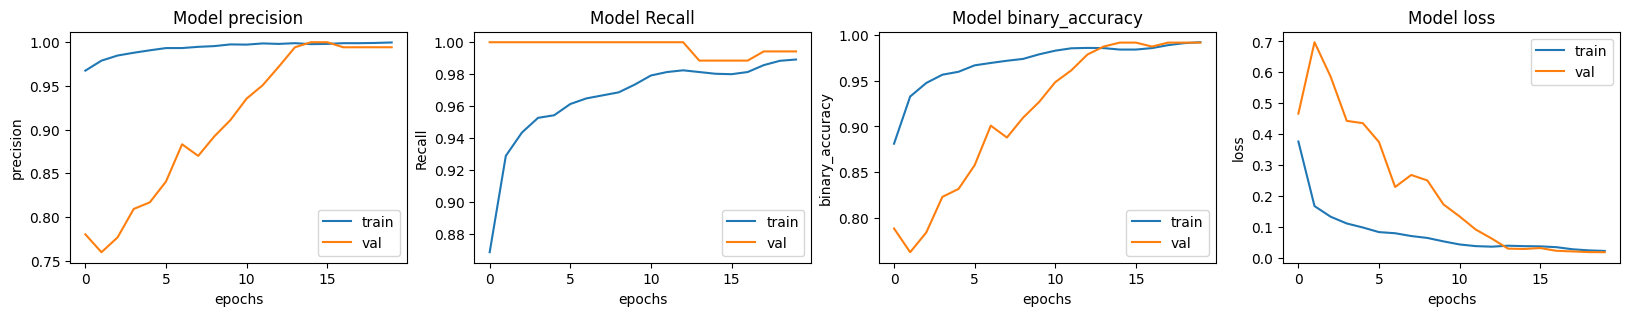

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "Recall", "binary_accuracy", "loss"]):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [21]:
loaded_mobilenet = tf.keras.models.load_model('model.h5')

In [31]:
loaded_mobilenet.evaluate(test_ds_batch)

20/20 [==============================] - 12s 246ms/step - loss: 1.5948 - binary_accuracy: 0.7708 - precision: 0.7380 - Recall: 0.9821


[1.5948405265808105,
 0.7708333134651184,
 0.7379575967788696,
 0.9820512533187866]

In [33]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i,layer.name,layer.output.shape)

4 expanded_conv_depthwise (None, 112, 112, 32)
5 expanded_conv_depthwise_BN (None, 112, 112, 32)
6 expanded_conv_depthwise_relu (None, 112, 112, 32)
7 expanded_conv_project (None, 112, 112, 16)
8 expanded_conv_project_BN (None, 112, 112, 16)


In [34]:
last_conv_layer_name = model.layers[8].name
last_conv_layer_name

'expanded_conv_project_BN'

2/2 [==============================] - 8s 339ms/step
This image is 10.78 percent NORMAL
This image is 89.22 percent PNEUMONIA


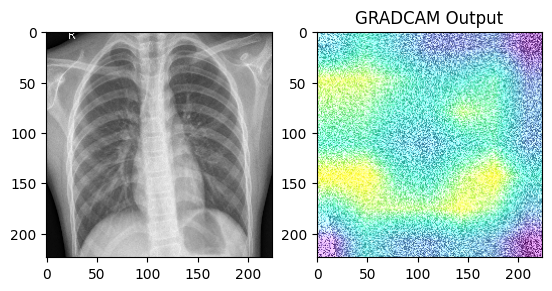

In [38]:
from tf_explain.core.grad_cam import GradCAM
import random

for image, label in test_ds_batch.take(2):

    data = ([image[2].numpy()], None)
    # print('Original label',CLASS_NAMES[label[2].numpy()])
    image = image[2] / 255

prediction = model.predict(test_ds_batch.take(2))[2]
scores = [1 - prediction, prediction]

for score, name in zip(scores, class_name):
    print("This image is %.2f percent %s" % ((100 * score), name))

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, model,class_index = 0)

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2)

axarr[0].imshow(image)
axarr[1].imshow(grid)
# axarr[0].title.set_text(f"{float(prediction)*100:.2f}% penumonia predicted")
axarr[1].title.set_text('GRADCAM Output')
plt.show()